# 利用sklearn对沪深300股票做聚类
数据源
------
数据源可以从tushare上取沪深300的成分股代码及名称，然后依次调用行情接口获取每只股票在一个时间段内的价格数据

特殊处理
--------
由于windows上访问tushare抓取数据通道始终不通，这里首先通过外网服务器GCP抓取数据到csv，然后把csv拷贝到本地，然后此处通过读取csv文件的方式查询所需要的数据。


In [97]:
from pandas import Series,DataFrame
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold
from datetime import datetime
import sys

In [4]:
#数据的读取
hs300s = pd.read_csv('hs300.csv')
daily_prices = pd.read_csv('daily_price.csv')
#数据格式展示
hs300s.tail()

,Unnamed: 0,code,name,date,weight
295,295,1,平安银行,2017-09-01,0.89
296,296,600019,宝钢股份,2017-09-01,0.70
297,297,601088,中国神华,2017-09-01,0.39
298,298,826,启迪桑德,2017-09-01,0.16
299,299,2142,宁波银行,2017-09-01,0.37


In [5]:
daily_prices.tail()

,date,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover,symbol
64238,2017-01-09,3.76,3.80,3.79,3.75,177582.03,0.02,0.53,3.782,3.778,3.830,236457.98,222423.46,247314.79,0.14,603993
64239,2017-01-06,3.79,3.81,3.77,3.75,279386.44,-0.03,-0.79,3.768,3.785,3.843,240278.95,235924.33,254606.42,0.22,603993
64240,2017-01-05,3.78,3.82,3.80,3.77,236272.31,0.00,0.00,3.762,3.792,3.857,233141.86,225450.74,263994.18,0.18,603993
64241,2017-01-04,3.75,3.80,3.80,3.73,295050.81,0.05,1.33,3.758,3.798,3.871,217076.35,225239.88,283783.49,0.23,603993
64242,2017-01-03,3.72,3.76,3.75,3.71,193998.30,0.03,0.81,3.758,3.803,3.880,200188.70,224123.93,281625.85,0.15,603993


In [155]:
#输入数据处理
#symbols = np.array([str(sym).zfill(6) for sym in hs300s['code']]).T
symbols = hs300s['code']
names = hs300s['name'] 
#这里需要对齐进行 

#起止时间
start_date = datetime(2017, 1, 1).date()
end_date = datetime(2017, 12, 1).date()

In [132]:
quotes = []
for symbol in symbols:
    #由于抓取的沪深300股票不是每只股票都有所有的交易数据（tushare质量不咋地啊），因此需要处理所有股票交易日个数相同，即维度相同
    if len(daily_prices[daily_prices.symbol==symbol][:100])==100:
        quotes.append(daily_prices[daily_prices.symbol==symbol][:100])

In [136]:
close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])
#日价格变动信息携带了最多的信息
variation = close_prices - open_prices

In [138]:
# Learn a graphical structure from the correlations(建模)
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery（数据归一化）
X = variation.copy().T
X /= X.std(axis=0)

array([[-0.7982523 , -0.97670774, -0.10849133, ..., -0.68500025,
        -0.2273178 , -0.1469447 ],
       [ 2.83016725,  2.93012323,  1.73586134, ..., -1.34365434,
        -2.70508177, -2.35111525],
       [-1.05224167, -0.42975141, -0.325474  , ..., -0.23711547,
        -0.84107585,  0.22041705],
       ..., 
       [-0.14513678, -0.31254648, -0.05424567, ..., -0.60596176,
         0.15912246,  2.31437907],
       [-0.43541035, -0.03906831, -0.54245667, ...,  0.5796156 ,
        -1.1138572 , -0.18368088],
       [-0.36284196, -0.27347817,  0.        , ...,  0.23711547,
        -0.47736737,  2.02048966]])

In [140]:
#输入数据训练模型
edge_model.fit(X)

C:\Users\zn\Anaconda3\envs\test_py2\lib\site-packages\sklearn\covariance\graph_lasso_.py:230: RuntimeWarning: overflow encountered in multiply
  * coefs)
C:\Users\zn\Anaconda3\envs\test_py2\lib\site-packages\sklearn\covariance\graph_lasso_.py:232: RuntimeWarning: overflow encountered in multiply
  * coefs)
C:\Users\zn\Anaconda3\envs\test_py2\lib\site-packages\numpy\linalg\linalg.py:1741: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users\zn\Anaconda3\envs\test_py2\lib\site-packages\sklearn\covariance\graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
C:\Users\zn\Anaconda3\envs\test_py2\lib\site-packages\sklearn\covariance\graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)


GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

In [141]:
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()
n_labels

61

In [142]:
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

In [144]:
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

(0.0, 1.0, 0.0, 1.0)

In [145]:
# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

In [146]:
# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)

In [147]:
# Plot the edges
start_idx, end_idx = np.where(non_zero)

In [148]:
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

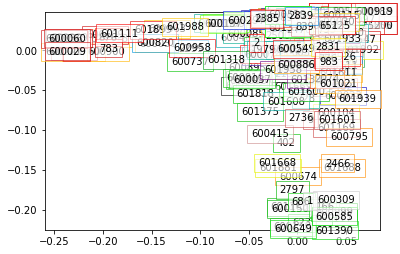

In [156]:
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))
plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()